In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
cat = Table(fitsio.read('/Users/rongpu/Documents/Data/dr9/dr9.0/temp/sweep-170p020-180p025.fits'))
print(len(cat))

ex_columns = ['NEA_G', 'NEA_R', 'NEA_Z', 'BLOB_NEA_G', 'BLOB_NEA_R', 'BLOB_NEA_Z']
cat1 = Table(fitsio.read('/Users/rongpu/Documents/Data/dr9/dr9.0/temp/sweep-170p020-180p025-ex.fits', columns=ex_columns))
cat = hstack([cat, cat1])

3703959


In [4]:
maskbits = [1, 8, 9, 11, 12, 13]
min_nobs = 2

cat_clean = np.ones(len(cat), dtype=bool)
for bit in maskbits:
    cat_clean &= (cat['MASKBITS'] & 2**bit)==0
print(np.sum(~cat_clean)/len(cat_clean))

cat_clean &= (cat['NOBS_G']>=min_nobs) & (cat['NOBS_R']>=min_nobs) & (cat['NOBS_Z']>=min_nobs)
print(np.sum(~cat_clean)/len(cat_clean))

cat = cat[cat_clean]
print(len(cat))

0.030241695439933325
0.04672459927337209
3530893


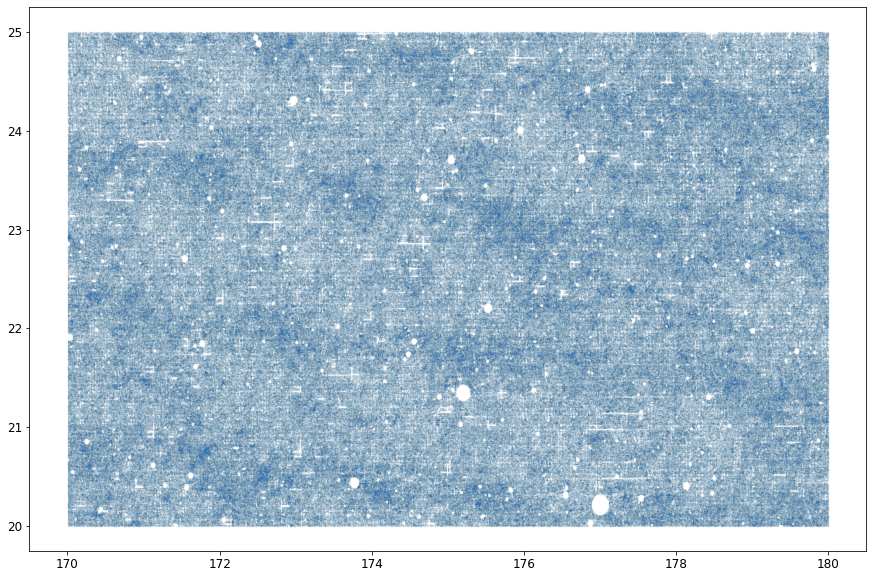

In [5]:
plt.figure(figsize=(15, 10))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.1, alpha=0.3)
# plt.axis([360, 0, -30, 35])
plt.show()

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gmag = 22.5 - 2.5*np.log10(cat['FLUX_G']/cat['MW_TRANSMISSION_G'])
    rmag = 22.5 - 2.5*np.log10(cat['FLUX_R']/cat['MW_TRANSMISSION_R'])
    zmag = 22.5 - 2.5*np.log10(cat['FLUX_Z']/cat['MW_TRANSMISSION_Z'])
    w1mag = 22.5 - 2.5*np.log10(cat['FLUX_W1']/cat['MW_TRANSMISSION_W1'])
    w2mag = 22.5 - 2.5*np.log10(cat['FLUX_W2']/cat['MW_TRANSMISSION_W2'])
    rfibermag = 22.5 - 2.5*np.log10(cat['FIBERFLUX_R']/cat['MW_TRANSMISSION_R'])
    zfibermag = 22.5 - 2.5*np.log10(cat['FIBERFLUX_Z']/cat['MW_TRANSMISSION_Z'])
    zfibertotmag = 22.5 - 2.5*np.log10(cat['FIBERTOTFLUX_Z']/cat['MW_TRANSMISSION_Z'])

    gmag[~np.isfinite(gmag)] = 100.
    rmag[~np.isfinite(rmag)] = 100.
    zmag[~np.isfinite(zmag)] = 100.
    w1mag[~np.isfinite(w1mag)] = 100.
    w2mag[~np.isfinite(w2mag)] = 100.
    rfibermag[~np.isfinite(rfibermag)] = 100.
    zfibermag[~np.isfinite(zfibermag)] = 100.
    zfibertotmag[~np.isfinite(zfibertotmag)] = 100.
    
    gflux_ivar = cat['FLUX_IVAR_R']
    
    gaia_g = cat['GAIA_PHOT_G_MEAN_MAG']
    
cat.add_columns([gmag, rmag, zmag, w1mag, w2mag, zfibermag, rfibermag], names=['gmag', 'rmag', 'zmag', 'w1mag', 'w2mag', 'zfibermag', 'rfibermag'])

In [8]:
mask_north = cat['RELEASE']%2==1
mask_south = cat['RELEASE']%2==0

# South
lrg_mask = mask_south.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.6)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.14) * 1.8  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.33) * 1.  # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.3
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.9  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

mask_bright = (gaia_g!=0) & (gaia_g < 18)
lrg_mask &= (~mask_bright)

lrg_mask &= (zfibertotmag>17.5)

lrg_final_south = lrg_mask.copy()

# North
lrg_mask = mask_north.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.61)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.13) * 1.83  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.31) * 1.   # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.4
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.97  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

mask_bright = (gaia_g!=0) & (gaia_g < 18)
lrg_mask &= (~mask_bright)

lrg_mask &= (zfibertotmag>17.5)

lrg_final_north = lrg_mask.copy()

lrg_final = lrg_final_south | lrg_final_north
print(np.sum(lrg_final))

25508


In [9]:
cat = cat[lrg_final]
print(len(cat))

25508


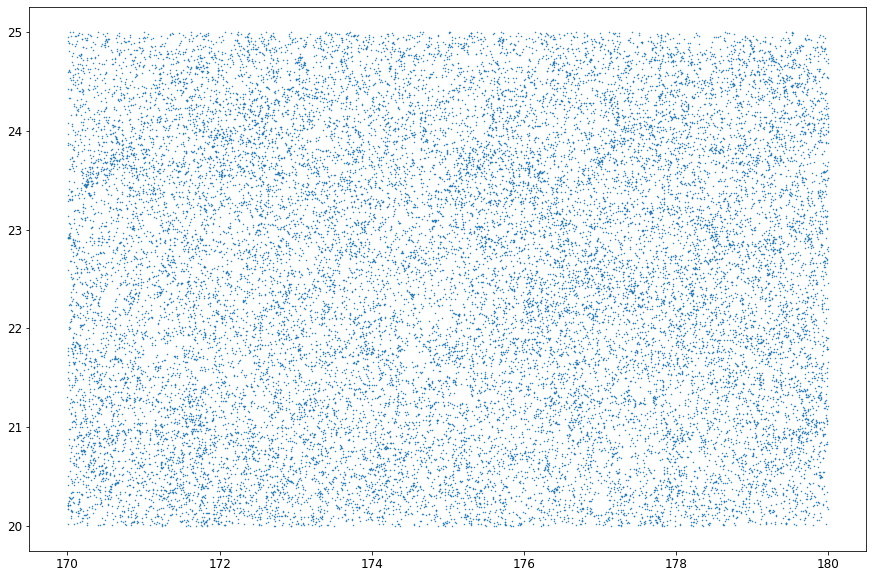

In [10]:
plt.figure(figsize=(15, 10))
plt.plot(cat['RA'], cat['DEC'], '.', ms=1, alpha=1)
# plt.axis([360, 0, -30, 35])
plt.show()

In [11]:
cat

RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_G,RCHISQ_R,RCHISQ_Z,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ANYMASK_G,ANYMASK_R,ANYMASK_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,WISEMASK_W1,WISEMASK_W2,PSFSIZE_G,PSFSIZE_R,PSFSIZE_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,WISE_COADD_ID,SHAPE_R,SHAPE_R_IVAR,SHAPE_E1,SHAPE_E1_IVAR,SHAPE_E2,SHAPE_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_CAT,REF_ID,REF_EPOCH,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,MASKBITS,FITBITS,SERSIC,SERSIC_IVAR,NEA_G,NEA_R,NEA_Z,BLOB_NEA_G,BLOB_NEA_R,BLOB_NEA_Z,gmag,rmag,zmag,w1mag,w2mag,zfibermag,rfibermag
int16,int32,str8,int32,str3,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str2,int64,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,uint8,float32,float32,float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
9010,460164,1752p230,32,SER,175.1205088054901,23.02912485889771,123519476000.0,105935990000.0,10451.729 .. 13718.574,0.027039321,2.4679708,11.333396,35.867226,80.35929,39.65659,159.55113,-388.68945,91.40411,27.553135,7.4707546,0.9135679,0.27487284,0.0003912314,6.7748206e-06,0.9230777,0.9475103,0.9702913,0.99542814,0.99718976,0.9994,0.9997734,2,2,3,184,183,12,12,0.9642921,1.2328156,1.2167785,8.694572,1.1525578,0.43402007,0.12485017,0.04225283,0.04337621,0.05589412,0.50660473,0.6525147,0.5136342,7.346164,0.096081115,0.09046782,0.09610954,0.7444149,0.7431212,0.7415179,0,0,0,0,0,0,0,0,1.5421555,1.27134,1.5953542,982.4986,402.16183,84.95034,652.3507,231.26279,52.294617,4.3315005,0.78378725,1759p227,5.0960426,180.1667,0.05483163,3128.2915,-0.44655347,6686.5176,0.42512313,1.9522471,6.17835,0.4251279,1.9522741,6.178437,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,6.0,74.32625,54.03321,45.835503,60.816315,55.217834,46.602974,62.160202,21.432245,19.80556,18.580511,17.732435,18.501156,20.490074,21.715122
9010,460164,1752p230,60,DEV,175.1217972104153,22.957221146575872,87500915000.0,74591740000.0,7458.0933 .. 9398.599,0.02615728,0.9523975,5.184642,18.972506,58.923023,31.264126,249.4776,-1126.683,245.34105,73.193726,19.795687,1.6298987,0.45732307,0.00060396444,9.349836e-06,0.925491,0.9491783,0.97124636,0.9955769,0.9972813,0.99941957,0.9997808,3,3,5,192,188,12,13,1.036054,1.0184392,1.0613909,4.514288,1.5000632,0.48614287,0.108258516,0.04851503,0.043227423,0.058283743,0.69136226,1.0208244

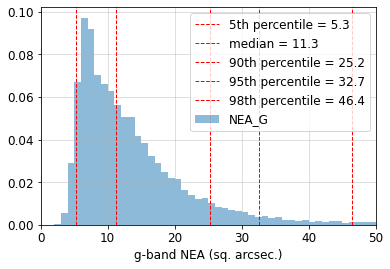

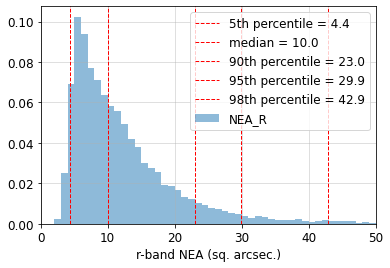

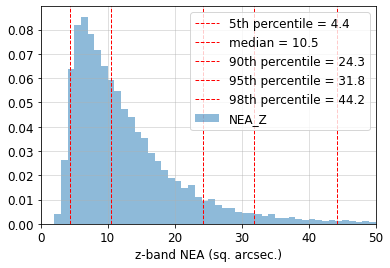

In [16]:
for col in ['NEA_G', 'NEA_R', 'NEA_Z']:
    # plt.hist(cat[col], 100, range=(0, 50), alpha=0.5, label=col)
    col1 = col.replace('nea', 'blob_nea')
    plt.hist(cat[col1], 50, range=(0, 50), alpha=0.5, label=col1, density=True)
    percentile = 5
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    v = np.median(cat[col1])
    plt.axvline(v, label='median = {:.1f}'.format(v), lw=1, color='r', ls='--')
    percentile = 90
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    percentile = 95
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    percentile = 98
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    plt.grid(alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('{}-band NEA (sq. arcsec.)'.format(col[-1].lower()))
    plt.xlim(0, 50)
    plt.show()

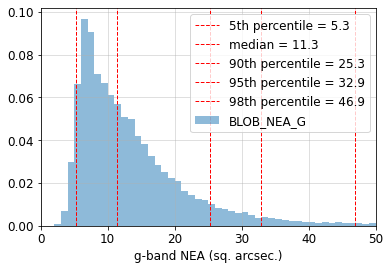

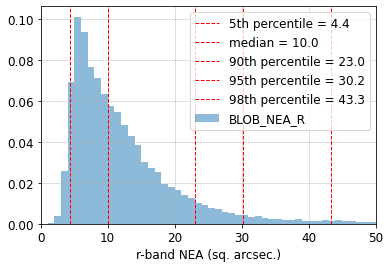

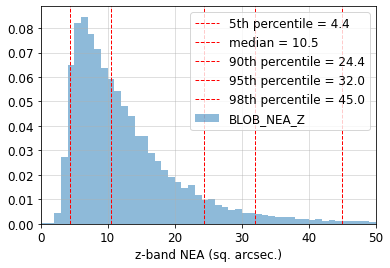

In [27]:
for col in ['BLOB_NEA_G', 'BLOB_NEA_R', 'BLOB_NEA_Z']:
    # plt.hist(cat[col], 100, range=(0, 50), alpha=0.5, label=col)
    col1 = col.replace('nea', 'blob_nea')
    plt.hist(cat[col1], 50, range=(0, 50), alpha=0.5, label=col1, density=True)
    percentile = 5
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    v = np.median(cat[col1])
    plt.axvline(v, label='median = {:.1f}'.format(v), lw=1, color='r', ls='--')
    percentile = 90
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    percentile = 95
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    percentile = 98
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    plt.grid(alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('{}-band NEA (sq. arcsec.)'.format(col[-1].lower()))
    plt.xlim(0, 50)
    plt.show()

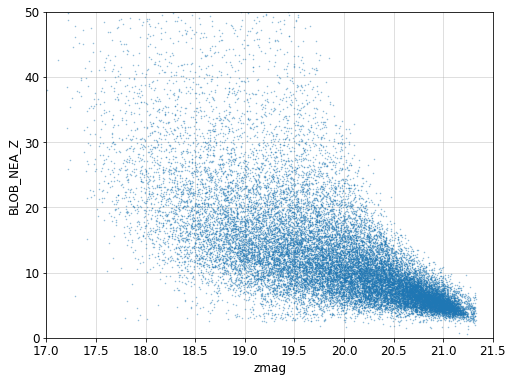

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(cat['zmag'], cat['BLOB_NEA_Z'], '.', ms=1, alpha=0.5)
plt.axis([17, 21.5, 0, 50])
plt.grid(alpha=0.5)
plt.xlabel('zmag')
plt.ylabel('BLOB_NEA_Z')
plt.show()

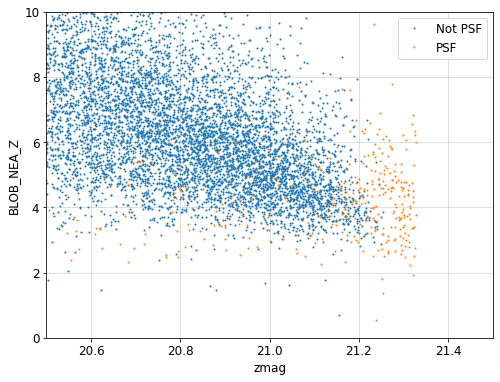

In [25]:
mask = cat['TYPE']=='PSF'

plt.figure(figsize=(8, 6))
plt.plot(cat['zmag'][~mask], cat['BLOB_NEA_Z'][~mask], '.', ms=2, alpha=1, label='Not PSF')
plt.plot(cat['zmag'][mask], cat['BLOB_NEA_Z'][mask], '.', ms=2, alpha=1, label='PSF')
plt.axis([20.5, 21.5, 0, 10])
plt.grid(alpha=0.5)
plt.xlabel('zmag')
plt.ylabel('BLOB_NEA_Z')
plt.legend()
plt.show()